In [201]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats

In [188]:
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams.update({'font.size': 14})

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as sts

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, update

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

I added the two below to see what was in the tables

In [11]:
f_rowM = session.query(Measurement).first()
f_rowM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29416e66908>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
f_rowS = session.query(Station).first()
f_rowS.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29417ee7d08>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

this code, similar to above, shows me the last row and gives me the final date (more on that below)

In [13]:
# this code, like above, shows me the last row and gives me the final date
l_rowM = session.query(Measurement).order_by(Measurement.date.desc()).first()
l_rowM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x29417eed188>,
 'station': 'USC00519397',
 'prcp': 0.0,
 'tobs': 81.0,
 'id': 2724,
 'date': '2017-08-23'}

I did all of this before the 3rd day of class, covering datetime.  I'm leaving my original solution below but realize that there are better ways to do some of this.

The 12 month report begins on 2016-08-23 and ends on 2017-08-23


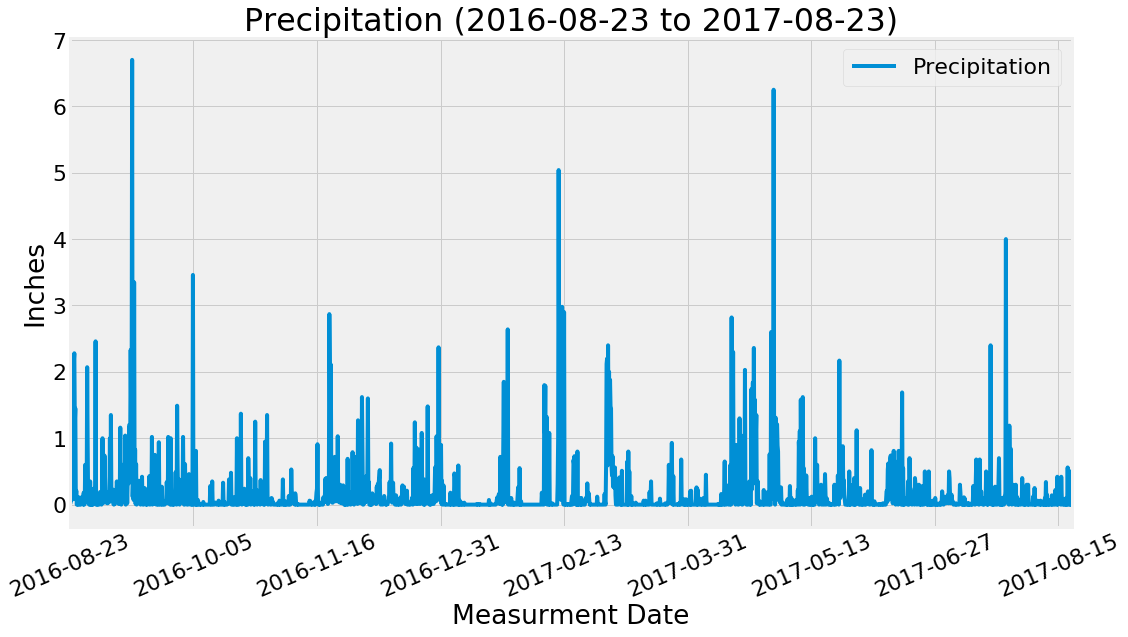

In [187]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database 

# Okay get the last day in the Measurment table
l_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day = l_day[0] # get like this for the query

# From there convert the string into a timestamp and subtract one year to get the start date....
f_day = pd.to_datetime(l_day[0], format='%Y-%m-%d')
f_day = f_day - pd.DateOffset(years=1)

# Then convert that back into a string to use in the query below
first_day = f_day.strftime('%Y-%m-%d') 
print(f'The 12 month report begins on {first_day} and ends on {last_day}')

# Perform a query to retrieve the date and precipitation scores
year_prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date.between(first_day, last_day))

# Save the query results as a Pandas DataFrame and set the index to the date column
dripdripdrip = pd.DataFrame(year_prcp, columns=['Measurment Date', 'Inches'])
dripdripdrip.set_index('Measurment Date', inplace=True, )

# clear NaN from dataframe
dripdripdrip = dripdripdrip.dropna(how='any')

# Sort the dataframe by date
prcp_1year = dripdripdrip.sort_values(["Measurment Date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_1year.plot(rot=23.5)
ax.set_title(f'Precipitation ({first_day} to {last_day})')
plt.xlabel("Measurment Date")
ax.set_ylabel('Inches')
plt.legend(['Precipitation'])
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# from the chart above?....
print(f"Here are the summary statistics from {first_day} to {last_day}")
print(prcp_1year.describe())
print()

# or from the whole thing?...
all_prcp = session.query(Measurement.date,Measurement.prcp)
all_measurements = pd.DataFrame(all_prcp, columns=['Measurment Date', 'Inches'])
all_measurements.set_index('Measurment Date', inplace=True, )
print(f"Here are the summary statistics for the whole data set")
print(all_measurements.describe())

Here are the summary statistics from 2016-08-23 to 2017-08-23
            Inches
count  2029.000000
mean      0.176580
std       0.460413
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

Here are the summary statistics for the whole data set
             Inches
count  18111.000000
mean       0.160573
std        0.468654
min        0.000000
25%        0.000000
50%        0.010000
75%        0.110000
max       11.530000


In [16]:
# Design a query to show how many stations are available in this dataset?

sta_num = session.query(Measurement.station).distinct().count() #distinct from class for the win
print(f'Measurements were taken from {sta_num} different stations.')

Measurements were taken from 9 different stations.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Ustations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

# station with the highest number of observations
Bigguy = Ustations[0][0] # this hurt my little brain

print(f'station with the highest number of observations -- {Bigguy}\n')
print('Decending list of all stations with their number of observations\n')
for row in Ustations:
    print(f'{row[0]} -- {row[1]}')

station with the highest number of observations -- USC00519281

Decending list of all stations with their number of observations

USC00519281 -- 2772
USC00519397 -- 2724
USC00513117 -- 2709
USC00519523 -- 2669
USC00516128 -- 2612
USC00514830 -- 2202
USC00511918 -- 1979
USC00517948 -- 1372
USC00518838 -- 511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# this is only slightly different from class but took me a while to figure out.  
# My original solution (from before class day 3)is below

temps = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
temp_data = session.query(*temps).filter(Measurement.station==Bigguy).all()

# low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==Bigguy).all()
# high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==Bigguy).all()
# avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==Bigguy).all()

print(f'It looks like {Bigguy} recorded:\n\nA lowest temperature of {temp_data [0][0]}°F\n\
A highest temperature of {temp_data [0][1]}°F\n\
And an average temperature of {round(temp_data [0][2],1)}°F')

It looks like USC00519281 recorded:

A lowest temperature of 54.0°F
A highest temperature of 85.0°F
And an average temperature of 71.7°F


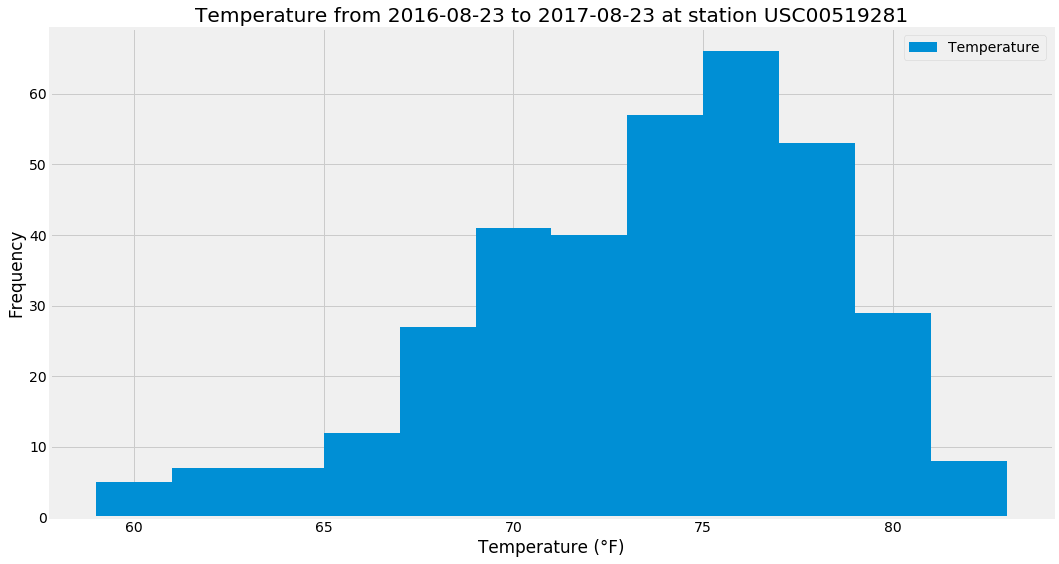

In [179]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# using variables from above (and cribbing the code too)
results = session.query(Measurement.tobs).filter(Measurement.station==Bigguy).filter\
    (Measurement.date.between(first_day, last_day)).all()

#trying this without a dataframe (from the class file)
temps = [int(result[0]) for result in results]

plt.hist(temps,bins=12)
plt.title(f'Temperature from {first_day} to {last_day} at station {Bigguy}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['Temperature'])
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

s_date = '2017-04-03'
e_date = '2017-04-15'

# There is blank data in the Measurement file for precipitation (None).  Since temptures have been recorded, I think 
# it is safe to assume that the blanks are zeros.  Rather than delete the rows I have updated them to zero precp.
for c in session.query(Measurement).filter(Measurement.date.between(s_date, e_date)).filter(Measurement.prcp == None).all():
    c.prcp = 0
session.commit()

vac_data = calc_temps(s_date, e_date)

print(f"Historic Tempture Data During Proposed Vacation Dates:\n\
(Taken from {s_date} to {e_date})\n\n\
Lowest temperature: {vac_data[0][0]}°F\n\
Average temperature: {vac_data[0][1]:.1f}°F\n\
Highest temperature: {vac_data[0][2]}°F")


Historic Tempture Data During Proposed Vacation Dates:
(Taken from 2017-04-03 to 2017-04-15)

Lowest temperature: 67.0°F
Average temperature: 74.3°F
Highest temperature: 82.0°F


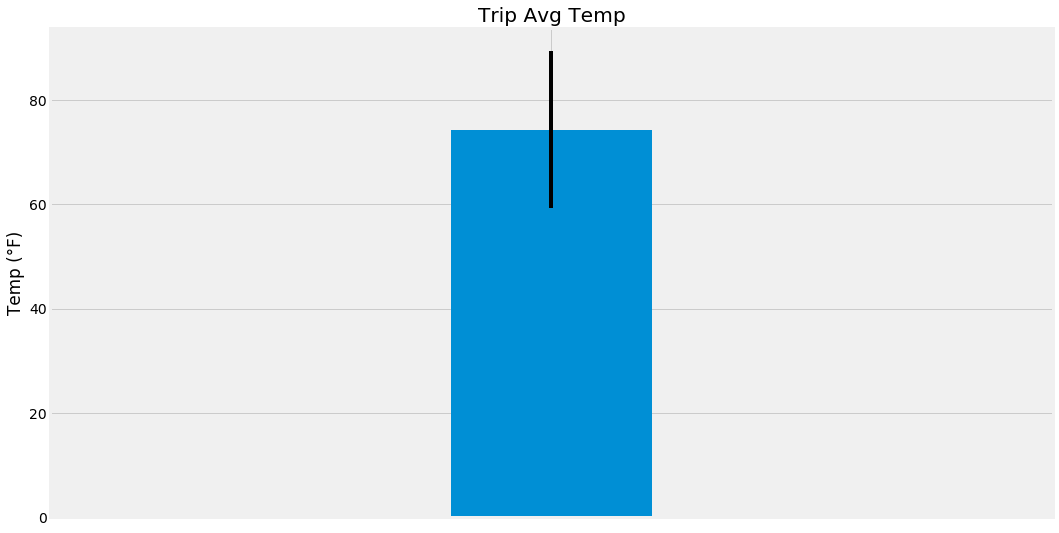

In [180]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
ax.bar(1,vac_data[0][1], yerr=vac_data[0][2]-vac_data[0][0]) #it looks right but I don't get it
ax.set_xlim(-1, 3) # this was fun on the bigger size chart
plt.title('Trip Avg Temp')
plt.ylabel('Temp (°F)')
plt.xticks([1], ('')) #remove x-ticks/lables
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.name, Measurement.station, Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp)]

RRGA = session.query(*sel).filter(Measurement.date.between(s_date, e_date)).filter(Measurement.station == Station.station)\
    .group_by(Station.name)\
    .order_by(func.sum(Measurement.prcp).desc()).all()

# I made it a dataframe for eaiser viewing.
Rain = pd.DataFrame(RRGA, columns=['Station Name', 'Station ID', 'Latitude', 'Longitude', 'Elevation', 'Total Rainfall'])
#Rain.set_index('Station Name', inplace=True, )
Rain

# That was fun and very dificult for me; that second filter had me stumped for a while.  I am never going to remember this

,Station Name,Station ID,Latitude,Longitude,Elevation,Total Rainfall
0,"MANOA LYON ARBO 785.2, HI US",USC00516128,21.33310,-157.80250,152.4,5.55
1,"WAIHEE 837.5, HI US",USC00519281,21.45167,-157.84889,32.9,3.93
2,"KANEOHE 838.1, HI US",USC00513117,21.42340,-157.80150,14.6,1.64
3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.52130,-157.83740,7.0,0.90
4,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,21.33556,-157.71139,19.5,0.36
5,"WAIKIKI 717.2, HI US",USC00519397,21.27160,-157.81680,3.0,0.27
6,"PEARL CITY, HI US",USC00517948,21.39340,-157.97510,11.9,0.00


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

*calculate the daily normals for your trip

*push each tuple of calculations into a list called `normals`

In [234]:
# Set the start and end date of the trip
# I used the start and end dates from the function `calc_temps` above (i.e. ...)
s_date = s_date
e_date = e_date

# Use the start and end date to create a range of dates
trip_dates = session.query(Measurement.date)\
        .filter(Measurement.date.between(s_date, e_date))\
        .group_by(Measurement.date).all()

# dates list for dateframe later
dates = [result[0] for result in trip_dates]
  
# Stip off the year and save a list of %m-%d strings
vac_days = []
for row in trip_dates:
    row = pd.to_datetime(row, format='%Y-%m-%d').strftime('%m-%d')
    vac_days.append(row[0],)
print(vac_days)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals= [daily_normals(row)[0] for row in vac_days]   
normals

['04-03', '04-04', '04-05', '04-06', '04-07', '04-08', '04-09', '04-10', '04-11', '04-12', '04-13', '04-14', '04-15']


[(55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0)]

In [204]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vac_temps = pd.DataFrame(normals, columns =['tmin', 'tavg', 'tmax']) 
vac_temps=vac_temps.assign(date = dates)
vac_temps.set_index('date', inplace=True, )

# Sort the dataframe by date
vac_temps = vac_temps.sort_values(["date"], ascending=True)
vac_temps

,tmin,tavg,tmax
date,,,
2017-04-03,55.0,72.228070,78.0
2017-04-04,58.0,72.016393,78.0
2017-04-05,61.0,72.288136,80.0
2017-04-06,67.0,71.571429,77.0
2017-04-07,63.0,71.105263,78.0
2017-04-08,66.0,72.105263,77.0
2017-04-09,62.0,71.614035,78.0
2017-04-10,64.0,71.403509,79.0
2017-04-11,65.0,72.491803,82.0


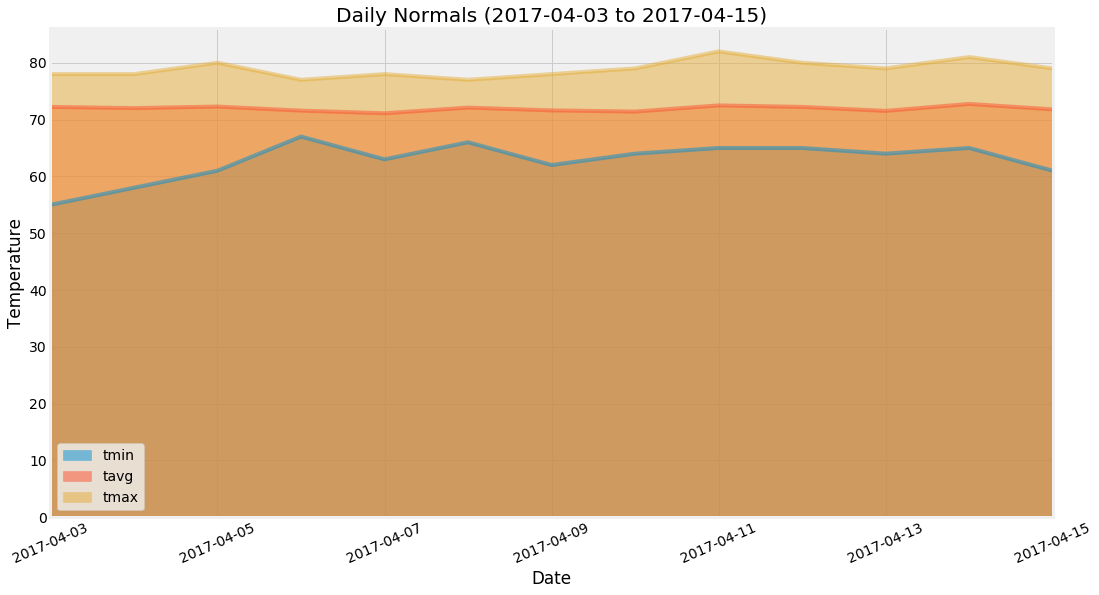

In [183]:
# Plot the daily normals as an area plot with `stacked=False`
ax = vac_temps.plot.area(stacked=False, fontsize=14,rot=23.5)
ax.set_title(f'Daily Normals ({s_date} to {e_date})')
plt.xlabel("Date")
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

## Bonus: Other Recommended Analyses

* I added this from the readme file, where it is listed as temperature analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [265]:
# Identify the average temperature in June at all stations across all available years in the dataset. 

# I grabbed every June dates (adjusting the function 'daily_normals' from above) put it into a dataframe and got the mean
juneBUG = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06')\
    .group_by(Measurement.date)\
    .order_by(func.sum(Measurement.date).desc()).all()
june_temps = pd.DataFrame(juneBUG, columns =['Dates', 'Temp'])
print(f'The average temperature in June (from all stations in all years) is - {june_temps["Temp"].mean():.1f}°F')

# same as above for June
decCHAIR = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12')\
    .group_by(Measurement.date)\
    .order_by(func.sum(Measurement.date).desc()).all()
dec_temps = pd.DataFrame(decCHAIR, columns =['Dates', 'Temp'])
print(f'In December that average temperature is - {dec_temps["Temp"].mean():.1f}°F')

The average temperature in June (from all stations in all years) is - 77.5°F
In December that average temperature is - 71.1°F


In [273]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant.

# I think this is the right Ttest since I have two data sets?  I'm a bit lost frankly.  Do I need the mean (second print)?
# I've been all over the place with this one, I got a result but I don't really understand

print(stats.ttest_ind(june_temps['Temp'], dec_temps['Temp'], equal_var=False))
print(stats.ttest_ind(june_temps["Temp"].mean(), dec_temps["Temp"].mean(), equal_var=False))

Ttest_indResult(statistic=23.8548814355496, pvalue=2.8799348751192233e-73)
Ttest_indResult(statistic=nan, pvalue=nan)
